In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import scipy
import matplotlib.pyplot as plt
from survival_analysis import setup, ats_fit, kaplan_meier

In [3]:
hdul = fits.open("Data/HI-MaNGA-Pipe3D-withMA.fits")
dataTable = Table(hdul[1].data)
dataTable # to see if it worked, we will print out the table

plateifu,mangaid_1,objra_1,objdec_1,log_SFR_Ha,e_log_Mass,e_log_SFR_Ha,log_Mass,log_Mass_gas,log_SFR_SF,PLATEIFU_1,MANGAID_2,OBJRA_2,OBJDEC_2,LOGMSTARS,SINI,VOPT,SESSION,EXP,RMS,LOGHILIM200KMS,PEAK,SNR,FHI,EFHI,LOGMHI,VHI,EV,WM50,WP50,WP20,W2P50,WF50,DW,PR,PL,AR,BR,AL,BL,NEGDET,BLSTRUCT,conflag,conf_prob,plateifu_2,ang_stellar,ang_stellar_err,ang_ha,ang_ha_err
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,str11,str9,float64,float64,float64,float64,float32,str111,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float64,str12,float32,float32,float32,float32
10001-12701,1-48157,133.371090612,57.5984251446,-0.0895131693945173,0.101380238282204,0.0925213500857353,10.2003526917592,9.72212893673082,-0.0896916174710324,10001-12701,1-48157,133.371090612,57.5984251446,9.428999281013443,0.927642710084122,11754.1,AGBT17A_012_19,896.8291,1.4207177,-999.0,0.0137383435,8.670002,3.313165,0.14617112,10.35004,11955.675,47.163033,432.4681,303.13943,434.7268,307.13962,287.3401,6.6275935,11.448619,7.819415,8.402823,0.02141115,56.474014,-0.34800306,0,0,1,0.8158912066758643,,nan,nan,nan,nan
10001-12702,1-48188,133.685669869,57.4802503218,-0.608526199959836,0.0890448767931129,0.0754329945892096,10.1912685783772,9.79847297302936,-0.610463914631434,10001-12702,1-48188,133.685669869,57.4802503218,9.666748170493861,0.8179359455005117,12234.8,AGBT17A_012_21,896.8445,1.4478949,-999.0,0.0053441967,2.6910114,0.542418,0.10295577,9.583724,12238.846,5.616053,229.21356,224.51225,230.25624,224.73874,223.7095,3.6541126,4.3635135,4.453497,22.229292,0.17453198,32.058037,-0.25722012,0,0,0,0.0,,nan,nan,nan,nan
10001-12703,1-55648,136.017159969,57.0923291779,0.100402942083708,0.0812002113521845,0.0599349962547421,10.5920939742321,10.105621643978,0.0993164003118889,10001-12703,1-55648,136.017159969,57.0923291779,9.974958652419431,0.9448822101276089,13853.2,AGBT17A_012_21,896.9,1.43424,-999.0,0.0062160227,4.33402,0.66,0.09151866,9.775859,13859.35,30.7268,390.53607,350.6874,388.82513,358.11423,362.01404,3.8883114,4.0,5.18,25.63,0.13,11.34,-0.05,0,0,0,0.0,,nan,nan,nan,nan
10001-12704,1-55616,133.989966869,57.6779676669,-0.465113695140934,0.0849644973102113,0.0942158468067646,9.97539222238386,9.53278982617368,-0.465329331268083,10001-12704,1-55616,133.989966869,57.6779676669,9.625145699270158,0.9973518809685926,4233.5,AGBT17A_012_19,897.2,1.63068,-999.0,0.011355257,6.96351,2.028,0.09155911,9.239542,4232.86,4.81335,289.92322,295.73117,289.3217,298.70914,292.1616,5.3867235,9.46,7.03,23.03,0.13,48.09,-0.3,0,0,0,0.0,,nan,nan,nan,nan
10001-12705,1-55784,136.75137451,57.4514369241,0.482522582767926,0.0942354027004969,0.0749382834881544,10.5282326867227,10.4591248799096,0.482210195786574,10001-12705,1-55784,136.75137451,57.4514369241,9.984605164340124,0.8582810369159054,13860.9,AGBT17A_012_21,896.9,1.2722402,-999.0,0.00589785,4.6358,0.81600004,0.08192676,9.8647175,13809.01,58.0585,387.08972,310.01324,387.15662,311.63812,368.958,4.0274525,3.7,4.91,2.04,-999.0,75.33,-0.38,0,0,0,0.0,,nan,nan,nan,nan
10001-1901,1-55567,133.330028009,57.0411553708,-0.892168989826935,0.0744959295039265,0.0713912613689899,9.77925212322796,8.96329368537905,-0.894111326140833,10001-1901,1-55567,133.330028009,57.0411553708,9.13950127473591,0.8639045486216899,7719.6,AGBT17A_012_19,896.9762,1.5561128,8.945167,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan
10001-1902,1-48201,134.193923352,56.7867469988,-2.70747732415461,0.0596789392162554,0.0560753542929888,10.5748640995477,nan,-3.26655386895031,10001-1902,1-48201,134.193923352,56.7867469988,10.05560383069523,0.5538396901353395,7612.0,AGBT17A_012_19-AGBT17A_012_21,946.79913,1.332848,8.865786,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-99

In [4]:
'''
Let's get a list of all of the columns, since it may be hard to refer to them just from looking at the cell output:
'''
columnNames = []
for column in dataTable.columns:
    columnNames.append(column)
print(columnNames)

['plateifu', 'mangaid_1', 'objra_1', 'objdec_1', 'log_SFR_Ha', 'e_log_Mass', 'e_log_SFR_Ha', 'log_Mass', 'log_Mass_gas', 'log_SFR_SF', 'PLATEIFU_1', 'MANGAID_2', 'OBJRA_2', 'OBJDEC_2', 'LOGMSTARS', 'SINI', 'VOPT', 'SESSION', 'EXP', 'RMS', 'LOGHILIM200KMS', 'PEAK', 'SNR', 'FHI', 'EFHI', 'LOGMHI', 'VHI', 'EV', 'WM50', 'WP50', 'WP20', 'W2P50', 'WF50', 'DW', 'PR', 'PL', 'AR', 'BR', 'AL', 'BL', 'NEGDET', 'BLSTRUCT', 'conflag', 'conf_prob', 'plateifu_2', 'ang_stellar', 'ang_stellar_err', 'ang_ha', 'ang_ha_err']


Let's first visualize the data by plotting all galaxies' positions, just to make sure everything is going smoothly so far. As we saw above, there are 6938 galaxies in the file now, though not all of them have data for all of their parameters.

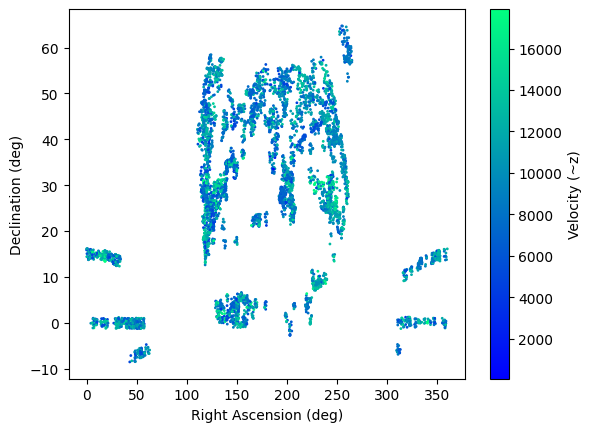

In [5]:
plot = plt.scatter(dataTable['objra_1'], dataTable['objdec_1'], c = dataTable['VOPT'], cmap = 'winter', s=1)
plt.colorbar(plot, label = 'Velocity (~z)')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.show()

Now we can start looking at the relevant data; the position angles of the gas and stellar disks, and the HI deficiencies of the galaxies. First, lets just plot the galaxies' masses of gas as a function of stellar mass.

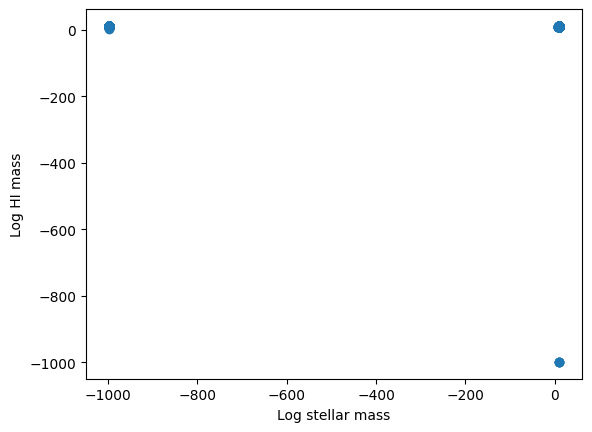

In [6]:
plt.scatter(dataTable['LOGMHI'], dataTable['LOGMSTARS'])
plt.xlabel('Log stellar mass')
plt.ylabel('Log HI mass');

Hmm... it looks like we have outliers. Non-detections are recorded as having values of -999, so we need to make sure we select the right data points. Let's make arrays that select for the useful data.

In [7]:
allGalStellarMass = []
allGalGasMass = []
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0:
        allGalStellarMass.append(gal['LOGMSTARS'])
        allGalGasMass.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']))

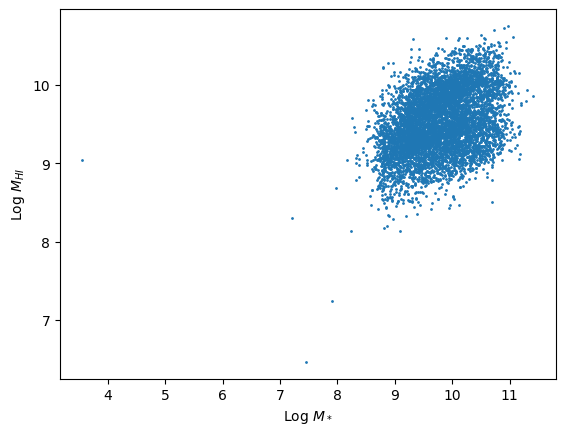

In [8]:
plt.scatter(allGalStellarMass, allGalGasMass, s=1)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $M_{HI}$');

Good! We've removed our non-detection outliers (though we've just assumed that our non-detection upper limits for HI mass are true values, which isn't quite right. We'll have to account for that later with statistical methods, i.e. survival analysis). Now, let's revise this data to represent mass fraction, the log of the ratio of gas mass to stellar mass

In [9]:
allGalMassFraction = [0]*len(allGalStellarMass)
for i in range(len(allGalStellarMass)):
    allGalMassFraction[i] = allGalGasMass[i] - allGalStellarMass[i]

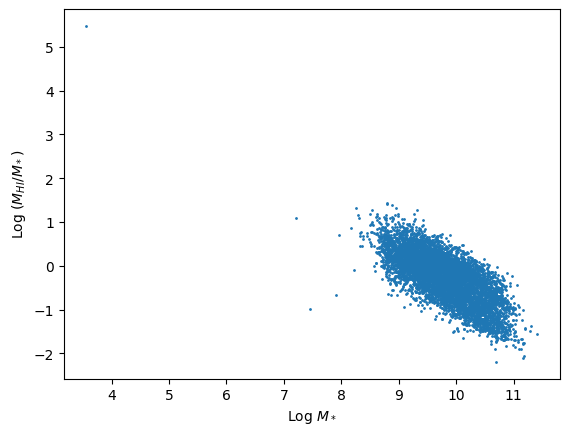

In [10]:
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.scatter(allGalStellarMass, allGalMassFraction, s=1);

We'll also change the bounds of the plot to exclude the one point far from the rest of the data (in the top left corner), which will allow us to improve the readability of the plot without skewing the data (though we should keep in mind that some data is not being shown).

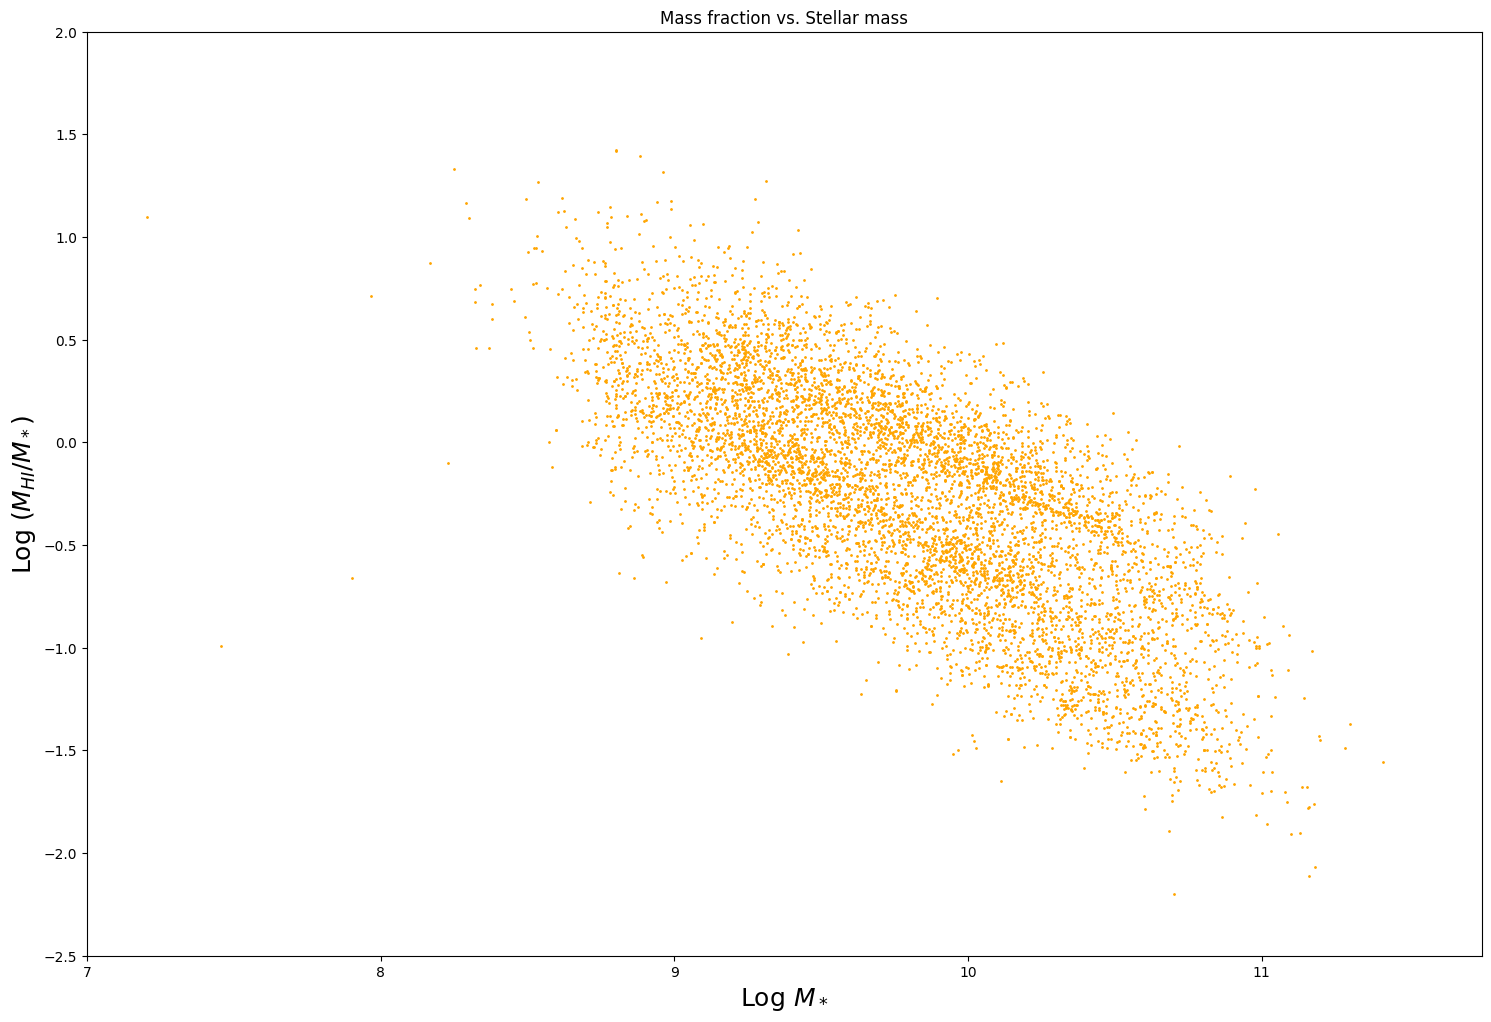

In [11]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.title('Mass fraction vs. Stellar mass')
plt.scatter(allGalStellarMass, allGalMassFraction, s=1, color='orange');

Our data is becoming quite readable, and we have shown a general trend in galaxies that galaxies with greater stellar masses have lower mass fractions. What we want, however, is to compare the mass fractions of the well-aligned galaxies (that is, small differences in position angles between their discs) to the misaligned galaxies (larger differences in position angles). Therefore, lets make arrays for these more specific categories:

In [12]:
alignedMStars = []
alignedMFrac = []
MAMStars = [] #MA meaning 'misaligned'
MAMFrac =[]
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] == '': # the misaligned galaxies will have values for this column, which was taken from the fits image of just misaligned galaxies, while the aligned galaxies will not
        alignedMStars.append(gal['LOGMSTARS'])
        alignedMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] != '':
        MAMStars.append(gal['LOGMSTARS'])
        MAMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

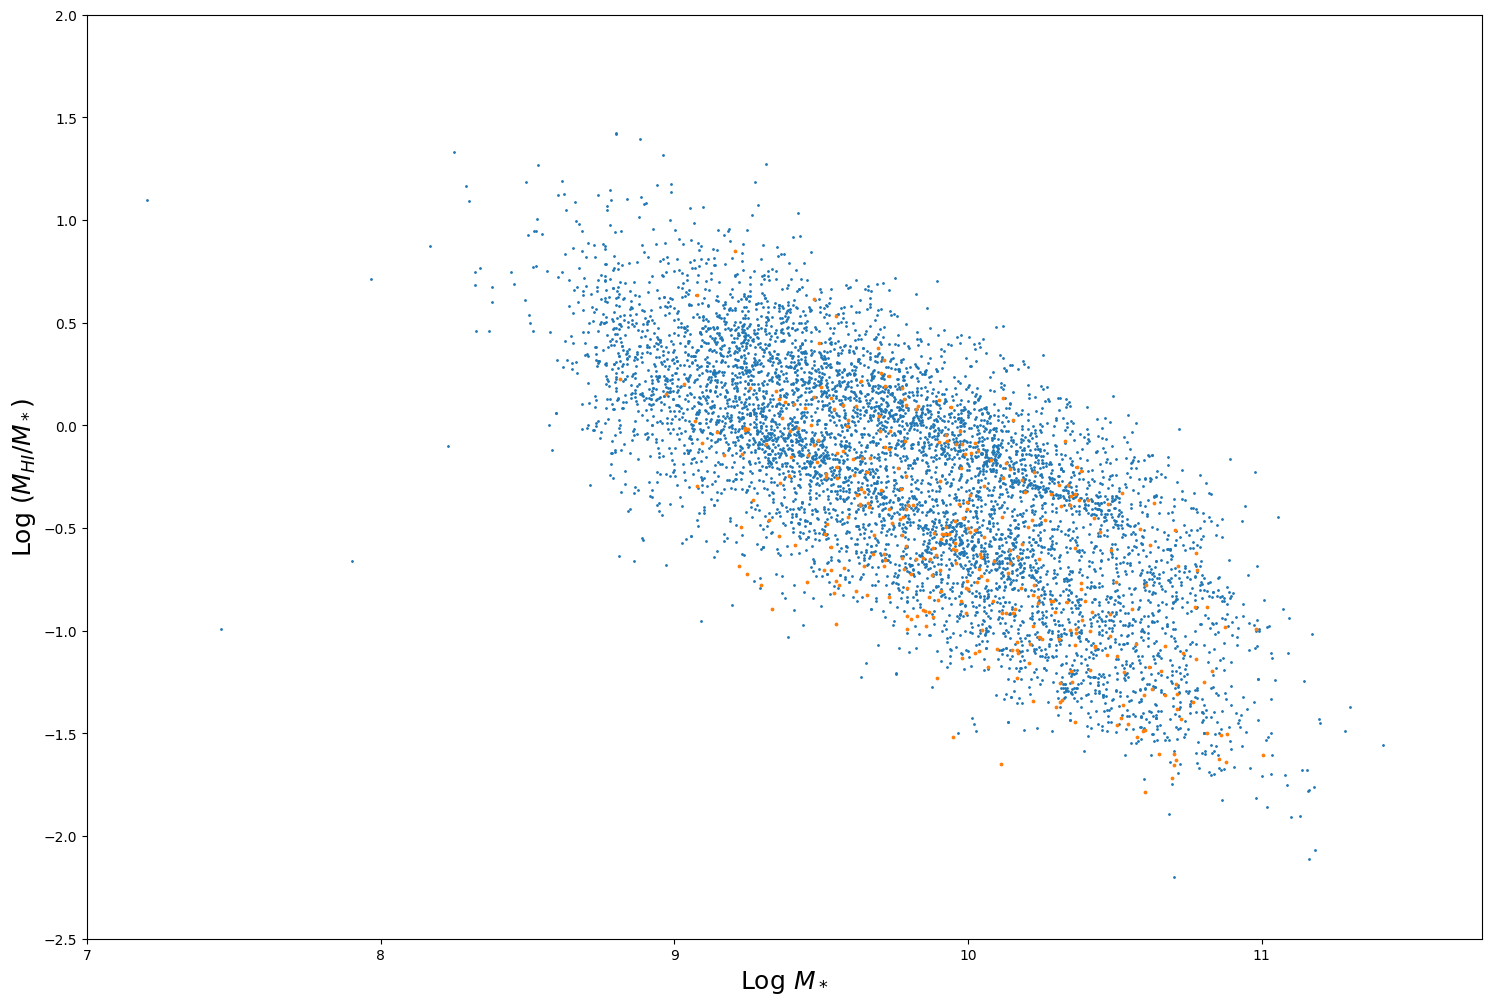

In [13]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1)
plt.scatter(MAMStars, MAMFrac, s=3);

Great! We've picked out the points that correspond to misaligned galaxies from those corresponding to well-aligned galaxies. To make this analysis more qualitative, let's fit trends to each set of data.

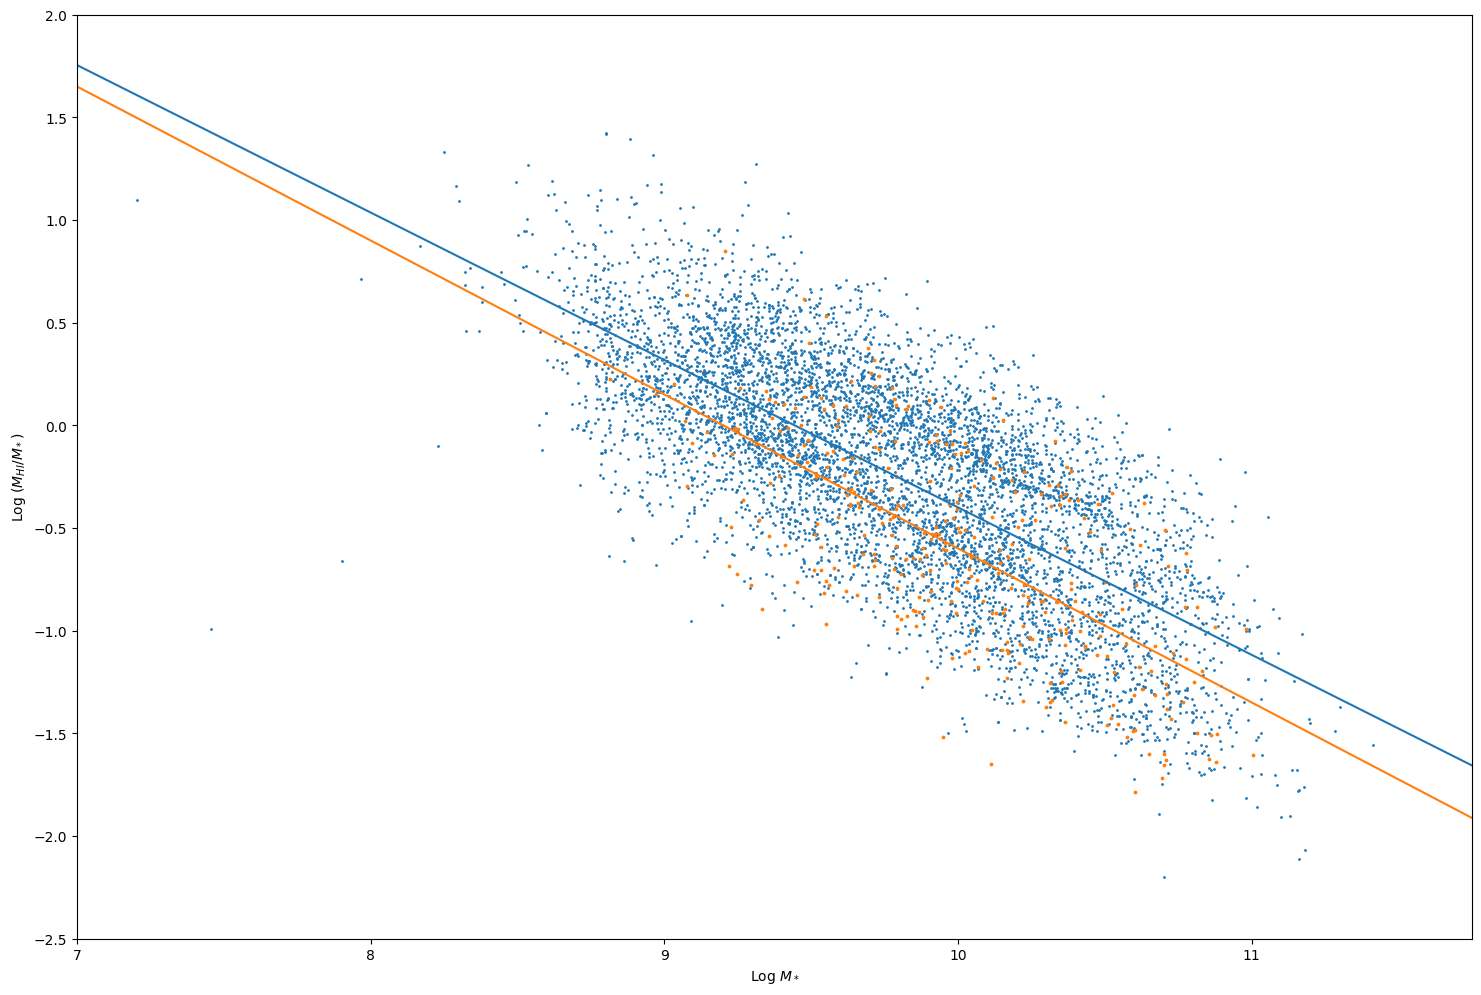

In [14]:
WAlinFit = np.polyfit(alignedMStars, alignedMFrac, 1)
MAlinFit = np.polyfit(MAMStars, MAMFrac, 1)
alignedAr = [[6, 13],[6*WAlinFit[0] + WAlinFit[1], 13*WAlinFit[0] + WAlinFit[1]]]
MAAr = [[6, 13],[6*MAlinFit[0] + MAlinFit[1], 13*MAlinFit[0] + MAlinFit[1]]]

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.scatter(alignedMStars, alignedMFrac, s=1)
plt.scatter(MAMStars, MAMFrac, s=3)
plt.plot(alignedAr[0], alignedAr[1])
plt.plot(MAAr[0], MAAr[1])

Interesting! It seems that misaligned galaxies actually have *less* gas than their well-aligned counterparts, which is not necessarily what we expect. Usually misalignment results from a recent accretion of new gas into the galaxy, gas which preserves its angular momentum therefore creating a misaligned gas disc. This suggests that the processes at play are more complicated than they appear, but we can make the trends more precise. Let's bin the data into segments. This binning code is modified from Patrick Wang (Haverford College '27).

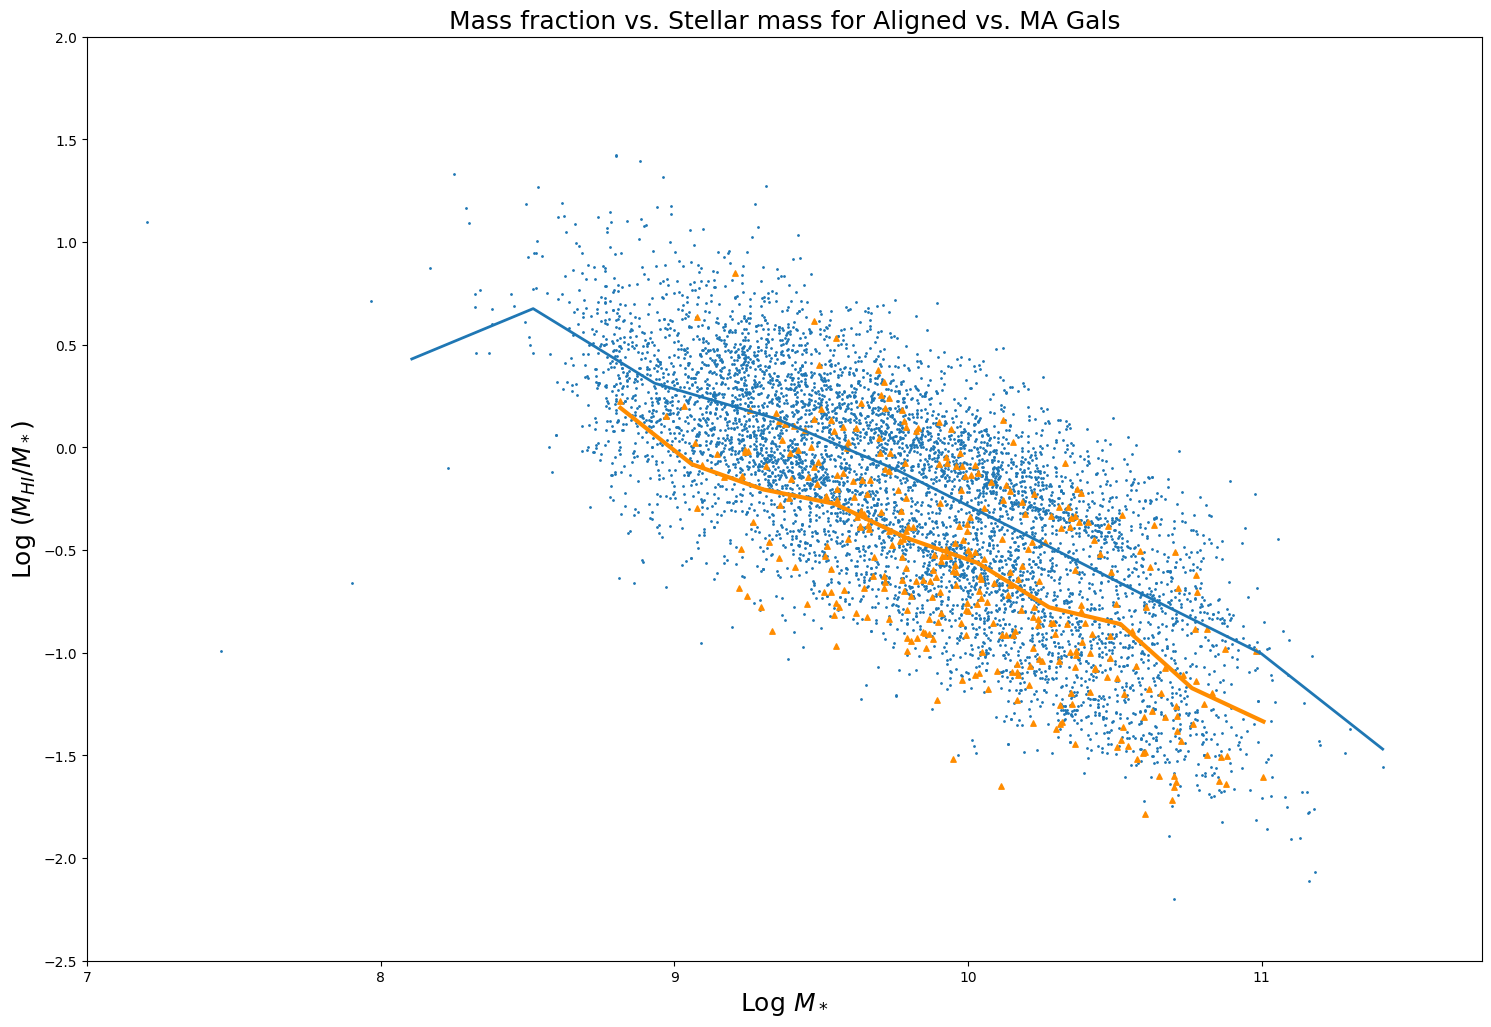

In [15]:
alignedBin = scipy.stats.binned_statistic(alignedMStars, alignedMFrac, 'mean', bins=20)
alignedXs = np.linspace(min(alignedMStars), max(alignedMStars), 20)

MABin = scipy.stats.binned_statistic(MAMStars, MAMFrac, 'mean', bins=10)
MAXs = np.linspace(min(MAMStars), max(MAMStars), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.title('Mass fraction vs. Stellar mass for Aligned vs. MA Gals', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue')
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^')

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange')
plt.show()

We still haven't analyzed any of the upper limits with proper statistical methods, but by binning the data we can show a more robust difference between the two data sets than with a simple linear fit. We've confirmed that there is indeed a correlation between galaxies having position angle misalignment, and having a greater HI deficiency than an aligned galaxy with the same stellar mass.

The last thing we'll do with this data before statistically analyzing the upper limits with survival anlysis techniques is to divide the misaligned galaxies into various degrees of misalignment. Let's first make a plot of frequency vs misalignment in order to decide what cutoff of misalignment we will consider to be "counter-rotating"

In [16]:
misalignedHA = []
misalignedStel = []
for gal in dataTable:
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            misalignedHA.append(360 - gal['ang_ha'])
        else:
            misalignedHA.append(gal['ang_ha'])
        if gal['ang_stellar'] > 180:
            misalignedStel.append(360 - gal['ang_stellar'])
        else:
            misalignedStel.append(gal['ang_stellar'])

misalignedDelPA = []
for i in range(len(misalignedHA)):
    misalignedDelPA.append(abs(misalignedHA[i] - misalignedStel[i]))

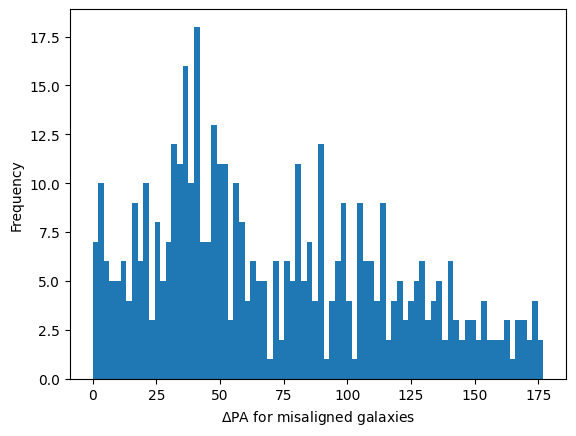

In [17]:
plt.figure()
plt.xlabel('$\Delta$PA for misaligned galaxies')
plt.ylabel('Frequency')
plt.hist(misalignedDelPA, bins=80);

There's no abundantly clear division. For now, let's just take all the galaxies with a misalignment of at least 90 degrees as 'counter-rotating,' and plot that data with binned averages.

In [18]:
counterMStel = []
counterFrac = []

for gal in dataTable:
    angHa = 0
    angStel = 0
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            angHa = 360 - gal['ang_ha']
        else:
            angHa = gal['ang_ha']
        if gal['ang_stellar'] > 180:
            angStel = 360 - gal['ang_stellar']
        else:
            angStel = gal['ang_stellar']
    if abs(angHa - angStel) >= 90 and str(gal['LOGMSTARS']) != 'nan':
        counterMStel.append(gal['LOGMSTARS'])
        counterFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

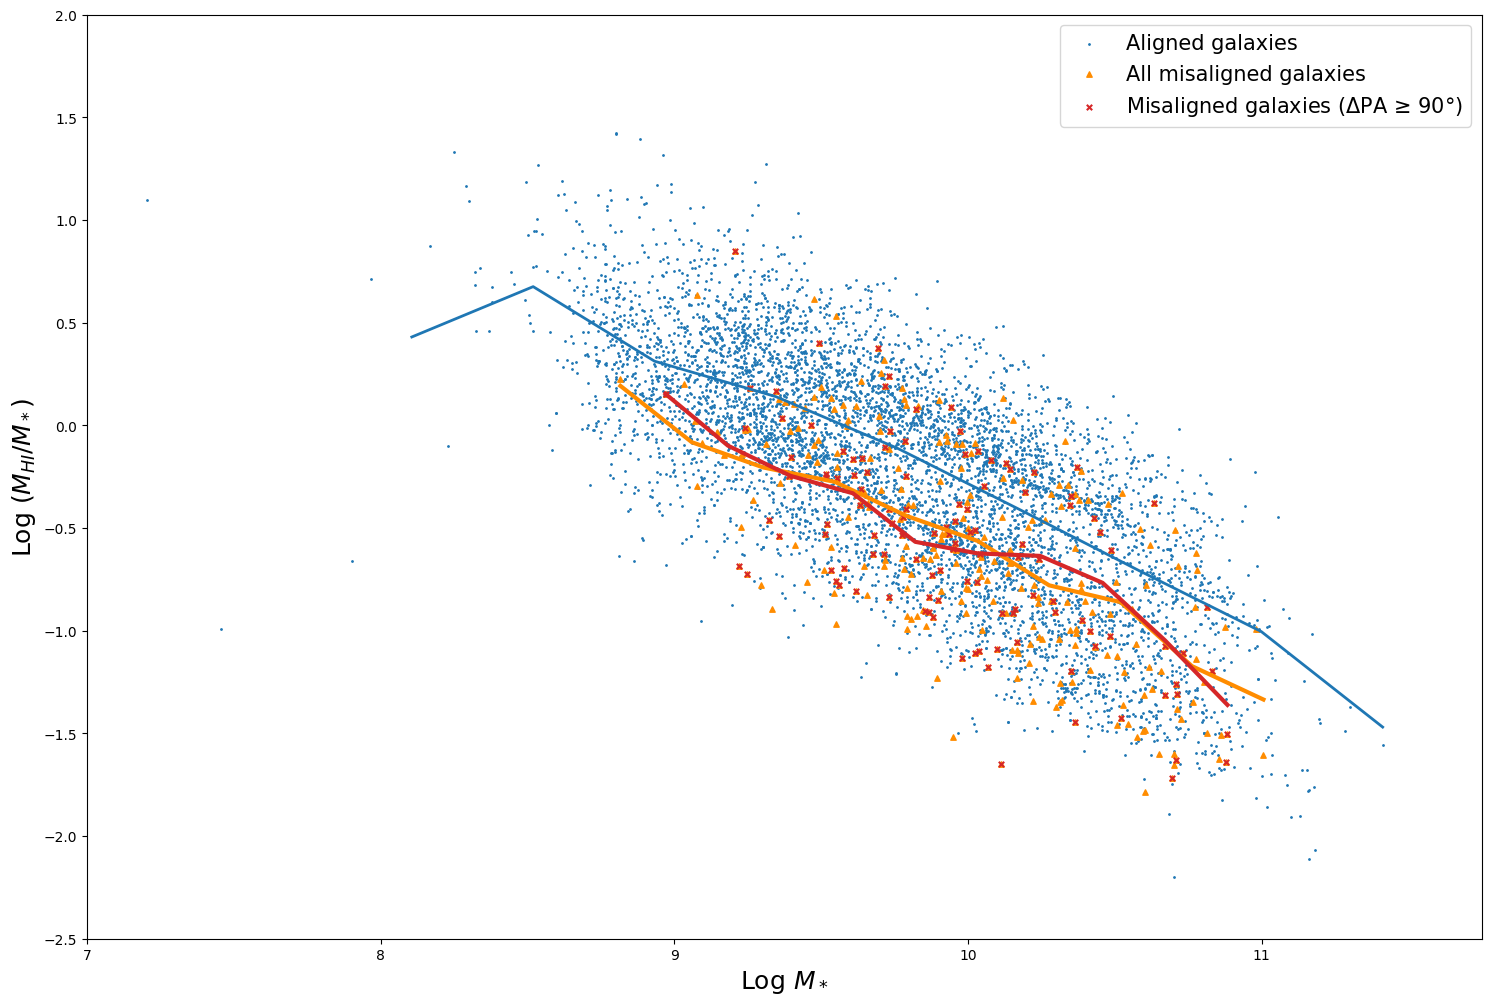

In [19]:
counterBin = scipy.stats.binned_statistic(counterMStel, counterFrac, 'mean', bins=10)
counterXs = np.linspace(min(counterMStel), max(counterMStel), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue', label='Aligned galaxies')
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^', label = 'All misaligned galaxies')
plt.scatter(counterMStel, counterFrac, s = 15, color = 'tab:red', marker = 'x', label = 'Misaligned galaxies ($\Delta$PA ≥ 90$\degree$)')

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange')
plt.plot(counterXs, counterBin[0], lw = 3, color='tab:red')
plt.legend(fontsize = 15)
# plt.savefig('mFrac_vs_mStel_binned.png')
plt.show()

Seeing that the counter-rotating galaxies (somewhat arbitrarily chosen to be those with ∆PA ≥ 90 degrees) display similar trends to the misaligned galaxies as a whole, which is noteworthy, I will choose to consider all misaligned galaxies for the remainder of this notebook for the larger sample size.

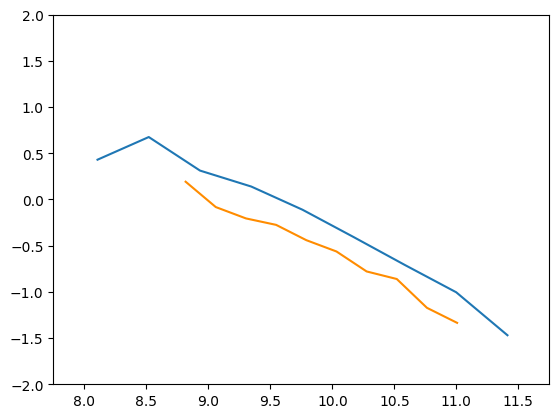

In [20]:
plt.xlim(7.75, 11.75)
plt.ylim(-2, 2)
plt.plot(alignedXs, alignedBin[0], color = 'tab:blue')
plt.plot(MAXs, MABin[0], color = 'darkorange');

Interestingly, we see that the group of all misaligned galaxies and the counter-rotating galaxies have very similar HI deficiencies, rather than the counter rotators having a more pronounced HI deficiency than other, less misaligned galaxies. However, we have still established a clear trend of misaligned galaxies having higher HI deficiencies than their well-aligned counterparts at their given stellar masses.

To quantify this deficiency, we can plot the difference between the HI deficiencies of the aligned galaxies and the HI deficiencies of the mis-aligned galaxies. Seeing that the counter-rotating galaxies have fairly similar trends to the mis-aligned galaxies as a whole, we will use the latter set, since it gives us more data points with which to work.

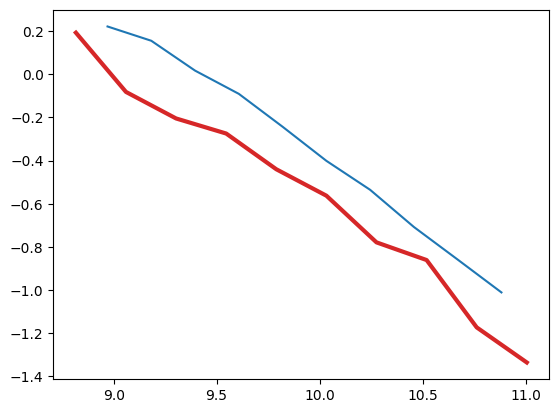

In [21]:
MABinDiff = [0]*10 # array of binned differences in HI deficiencies (on average, how deficient are each stellar mass's misaligned galaxies compared to that stellar mass's well-aligned galaxies)
limitedBin = []
limitedXs = []

for gal in dataTable:
    if max(counterXs) >= gal['LOGMSTARS'] >= min(counterXs) and str(gal['plateifu_2']) == '' and (gal['LOGMHI'] > 0 or gal['LOGHILIM200KMS'] > 0):
        limitedBin.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
        limitedXs.append(gal['LOGMSTARS'])

limitedAlignedBin = scipy.stats.binned_statistic(limitedXs, limitedBin, 'mean', bins=10)

plt.plot(np.linspace(min(limitedXs), max(limitedXs), 10), limitedAlignedBin[0], color = 'tab:blue')

for i in range(10):
    MABinDiff[i] =  limitedAlignedBin[0][i] - MABin[0][i]

#plt.plot(MAXs, MABinDiff);
plt.plot(MAXs, MABin[0], lw = 3, color='tab:red');

And we can normalize this plot, taking the difference between the two heights

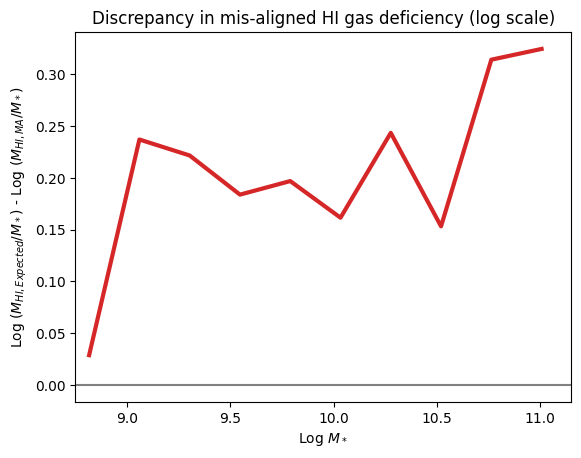

In [22]:
plt.xlim(8.75, 11.15)
plt.plot(MAXs, MABinDiff, lw = 3, color='tab:red')
plt.plot([5, 15], [0, 0], color = 'grey')
plt.title('Discrepancy in mis-aligned HI gas deficiency (log scale)')
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI, Expected}/M_*)$ - Log $(M_{HI, MA}/M_*)$')
plt.show()

We can convert this log scale to percentages to understand the significance of this data:

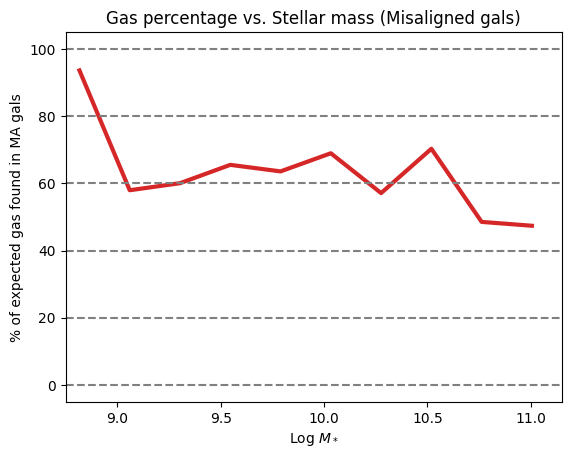

In [23]:
plt.xlim(8.75, 11.15)

MABinDiffPerc = [0]*10
for i in range(10):
    MABinDiffPerc[i] = 10**(-MABinDiff[i]) * 100

plt.xlabel('Log $M_*$')
plt.ylabel('% of expected gas found in MA gals')
plt.title('Gas percentage vs. Stellar mass (Misaligned gals)')
plt.plot(MAXs, MABinDiffPerc, lw = 3, color='tab:red')


plt.axhline(0, linestyle = '--', color = 'grey')
plt.axhline(20, linestyle = '--', color = 'grey')
plt.axhline(40, linestyle = '--', color = 'grey')
plt.axhline(60, linestyle = '--', color = 'grey')
plt.axhline(80, linestyle = '--', color = 'grey')
plt.axhline(100, linestyle = '--', color = 'grey')
plt.show()

From this plot, we can see that misaligned galaxies can have 60-70% of the HI gas as we expect from a well-aligned galaxy at their given stellar mass, which is an extremely large difference.

To take binned *medians*, with error bars, we will include upper limits as accepted values. The following code is again modified from Patrick Wang (HC '27)


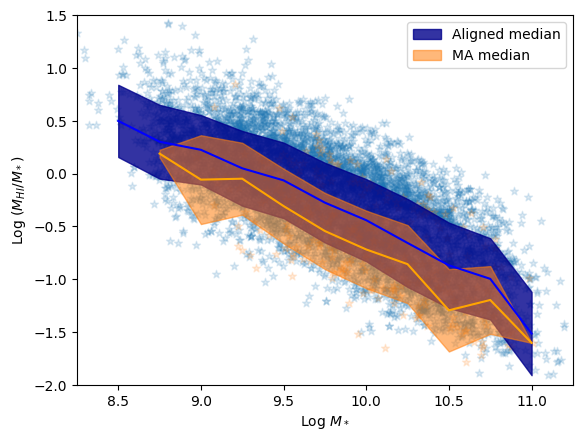

In [24]:
plt.xlim(8, 11.5)
plt.ylim(-2.5, 2)

Alignedmedians, Alignededgesmedian, Alignednummedian = scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'median',bins=np.arange(8.5,11.5,0.25))
Alignedstds, Alignededgesstd, Alignednumstd=scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'std',bins=np.arange(8.5,11.5,0.25))

MAmedians, MAedgesmedian, MAnummedian = scipy.stats.binned_statistic(MAMStars, MAMFrac, statistic = 'median', bins=np.arange(8.5,11.5,0.25))
MAstds,MAedgesstd,MAnumstd=scipy.stats.binned_statistic(MAMStars,MAMFrac, statistic = 'std', bins=np.arange(8.5,11.5,0.25))

plt.scatter(alignedMStars, alignedMFrac, marker = '*', color='tab:blue', alpha=0.15)
plt.scatter(MAMStars, MAMFrac, marker = '*', color='tab:orange', alpha=0.15)

#plotting binned data by using the edges of the bins
plt.plot(Alignededgesmedian[:-1], Alignedmedians, ls='-', alpha=1, color='blue')
plt.plot(MAedgesmedian[:-1], MAmedians, ls='-', alpha=1, color='orange')

#highlighting the standard deviation of this binned data
plt.fill_between(Alignededgesmedian[:-1],Alignedmedians-Alignedstds,Alignedmedians+Alignedstds,alpha=.8, color='darkblue', label='Aligned median')
plt.fill_between(MAedgesmedian[:-1],MAmedians-MAstds,MAmedians+MAstds,alpha=.55, color='tab:orange', label='MA median')
plt.legend()
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.ylim(-2, 1.5)
plt.xlim(8.25, 11.25)
plt.show()

In [25]:
medianMStel = []
medianMFracDiff = []
adjustedDiff = []

for i in range(10):
    if MAmedians[i] > -100:
        medianMStel.append(Alignededgesmedian[:-1][i])
        medianMFracDiff.append(Alignedmedians[i] - MAmedians[i])
        adjustedDiff.append(100 * 10**(-1 * (Alignedmedians[i] - MAmedians[i])))


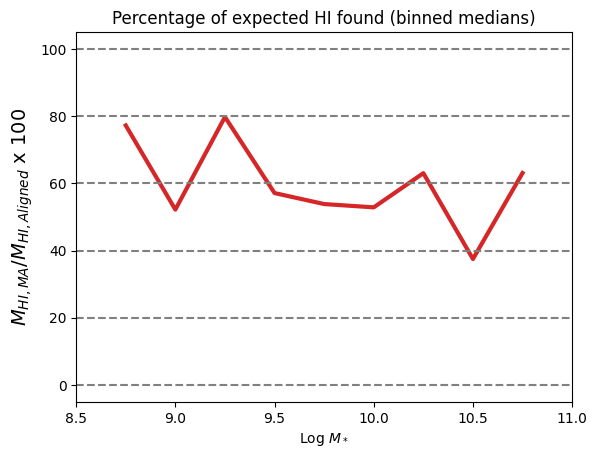

In [26]:
plt.plot(medianMStel, adjustedDiff, lw = 3, color='tab:red')
plt.axhline(0, linestyle = '--', color = 'grey')
plt.axhline(20, linestyle = '--', color = 'grey')
plt.axhline(40, linestyle = '--', color = 'grey')
plt.axhline(60, linestyle = '--', color = 'grey')
plt.axhline(80, linestyle = '--', color = 'grey')
plt.axhline(100, linestyle = '--', color = 'grey')
plt.xlim(8.5, 11)
plt.title('Percentage of expected HI found (binned medians)')
plt.xlabel('Log $M_*$')
plt.ylabel('$M_{HI, MA}/M_{HI, Aligned}$ x 100', fontsize=14);

**Survival Analysis:** In order to do survival analysis, we'll need to first create new data sets corresponding to the detections vs upper limis (non-detections). The detections will have entries in the 'LOGMHI' column of the fits image (other than 'NaN' or -999), while the non-detections will have entries in the 'LOGLIMHI200KMS' column (other than 'NaN' or -999). Also, we've just shown a distinct but fluctuating HI deficiency in misaligned galaxies with binned data, but for purposes of survival analysis, we'll be using a simple linear fit (at least for now).

In [27]:
WADetectionStel = []
WADetectionFrac = []
WALimStel = []
WALimFrac = []

MADetectionStel = []
MADetectionFrac = []
MALimStel = []
MALimFrac = []

for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and gal['LOGMHI'] > 0: # Well-defined gas mass
        if gal['plateifu_2'] != '': # Misaligned, so has an entry from the misaligned galaxy fits file
            MADetectionStel.append(gal['LOGMSTARS'])
            MADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
        elif gal['plateifu_2'] == '': # Aligned, so does not
            WADetectionStel.append(gal['LOGMSTARS'])
            WADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
    elif gal['LOGMSTARS'] > 0 and gal['LOGHILIM200KMS'] > 0: # Upper limit/non-detection
        if gal['plateifu_2'] != '': # Misaligned, so has an entry from the misaligned galaxy fits file
            MALimStel.append(gal['LOGMSTARS'])
            MALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])
        elif gal['plateifu_2'] == '': # Aligned, so does not
            WALimStel.append(gal['LOGMSTARS'])
            WALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])

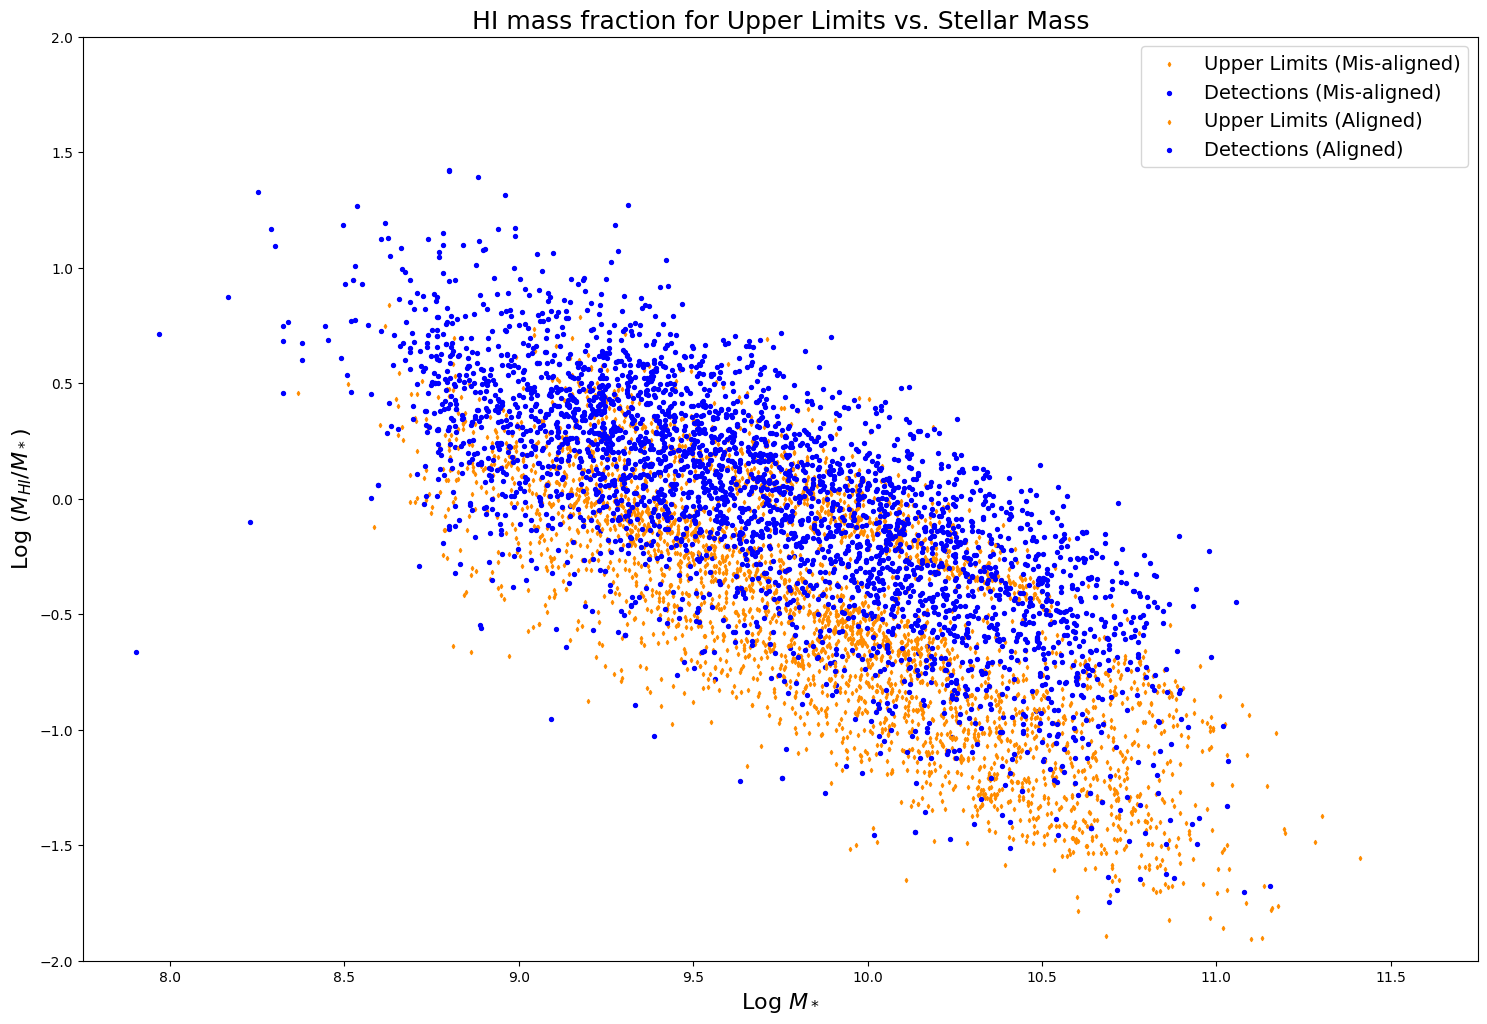

In [28]:
plt.figure(figsize=(18, 12))
plt.scatter(MALimStel, MALimFrac, label = 'Upper Limits (Mis-aligned)', s=4, marker='d', color='darkorange')
plt.scatter(MADetectionStel, MADetectionFrac, label = 'Detections (Mis-aligned)', s=8, color='blue')
plt.scatter(WALimStel, WALimFrac, label = 'Upper Limits (Aligned)', s=4, marker='d', color='darkorange')
plt.scatter(WADetectionStel, WADetectionFrac, label = 'Detections (Aligned)', s=8, color='blue')
plt.xlim(7.75, 11.75)
plt.ylim(-2, 2)
plt.legend(fontsize=14)
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16)
plt.title('HI mass fraction for Upper Limits vs. Stellar Mass', fontsize=18);
# plt.savefig('detectAndLim_with_alignedAndMA.png');

Using David Stark's survival analysis code, which wraps R statistical code for Python use, we can create a linear fits for the aligned galaxies (now performing statistical methods on this set which includes both detections and upper limits), and misaligned galaxies (similarly):

**Caution**: This cell takes 7 minutes to run, so if the data has not changed, refer to next cell

In [29]:
'''
alignedComboMStars = np.ndarray(shape = len(alignedMStars)).astype(float)
alignedComboMFrac = np.ndarray(shape = len(alignedMFrac)).astype(float)
MAComboMStars = np.ndarray(shape = len(MAMStars)).astype(float)
MAComboMFrac = np.ndarray(shape = len(MAMFrac)).astype(float)

AlignedLims = np.ndarray(shape = len(alignedMStars)).astype(bool);
MALims = np.ndarray(shape = len(MAMStars)).astype(bool);

alignedGalInc = 0
MAGalInc = 0

alignedInc = 0
MAInc = 0

for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] == '': # the misaligned galaxies will have values for this column, which was taken from the fits image of just misaligned galaxies, while the aligned galaxies will not
        alignedComboMStars[alignedGalInc] = gal['LOGMSTARS']
        alignedComboMFrac[alignedGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
        if gal['LOGHILIM200KMS'] > 0: # If an upper limit
            AlignedLims[alignedInc] = True
        else:
            AlignedLims[alignedInc] = False
        alignedGalInc += 1
        alignedInc += 1
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] != '':
        MAComboMStars[MAGalInc] = gal['LOGMSTARS']
        MAComboMFrac[MAGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
        if gal['LOGHILIM200KMS'] > 0:
            MALims[MAInc] = True
        else:
            MALims[MAInc] = False
        MAGalInc += 1
        MAInc += 1

AlignedOut = ats_fit(alignedComboMStars, alignedComboMFrac, AlignedLims, fmt='(I4, 2F10.3)');
MAOut = ats_fit(MAComboMStars, MAComboMFrac, MALims, fmt='(I4, 2F10.3)');


np.save('Data/alignedComboMStars.npy', alignedComboMStars)
np.save('Data/MAComboMStars.npy', MAComboMStars)
np.save('Data/alignedComboMFrac.npy', alignedComboMFrac)
np.save('Data/MAComboMFrac.npy', MAComboMFrac)
np.save('Data/AlignedLims.npy', AlignedLims)
np.save('Data/MALims.npy', MALims)
np.save('Data/alignedOut.npy', AlignedOut)
np.save('Data/MAOut.npy', MAOut)
'''

"\nalignedComboMStars = np.ndarray(shape = len(alignedMStars)).astype(float)\nalignedComboMFrac = np.ndarray(shape = len(alignedMFrac)).astype(float)\nMAComboMStars = np.ndarray(shape = len(MAMStars)).astype(float)\nMAComboMFrac = np.ndarray(shape = len(MAMFrac)).astype(float)\n\nAlignedLims = np.ndarray(shape = len(alignedMStars)).astype(bool);\nMALims = np.ndarray(shape = len(MAMStars)).astype(bool);\n\nalignedGalInc = 0\nMAGalInc = 0\n\nalignedInc = 0\nMAInc = 0\n\nfor gal in dataTable:\n    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] == '': # the misaligned galaxies will have values for this column, which was taken from the fits image of just misaligned galaxies, while the aligned galaxies will not\n        alignedComboMStars[alignedGalInc] = gal['LOGMSTARS']\n        alignedComboMFrac[alignedGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']\n        if gal['LOGHILIM200KMS'] > 0: # If an upper limit\n         

In [30]:
alignedComboMStars = np.load('Data/alignedComboMStars.npy', allow_pickle=True)
MAComboMStars = np.load('Data/MAComboMStars.npy', allow_pickle=True)
alignedComboMFrac = np.load('Data/alignedComboMFrac.npy', allow_pickle=True)
MAComboMFrac = np.load('Data/MAComboMFrac.npy', allow_pickle=True)
AlignedOut = np.load('Data/alignedOut.npy', allow_pickle=True)
MAOut = np.load('Data/MAOut.npy', allow_pickle=True)
AlignedLims = np.load('Data/AlignedLims.npy', allow_pickle=True)
MALims = np.load('Data/MALims.npy', allow_pickle=True)

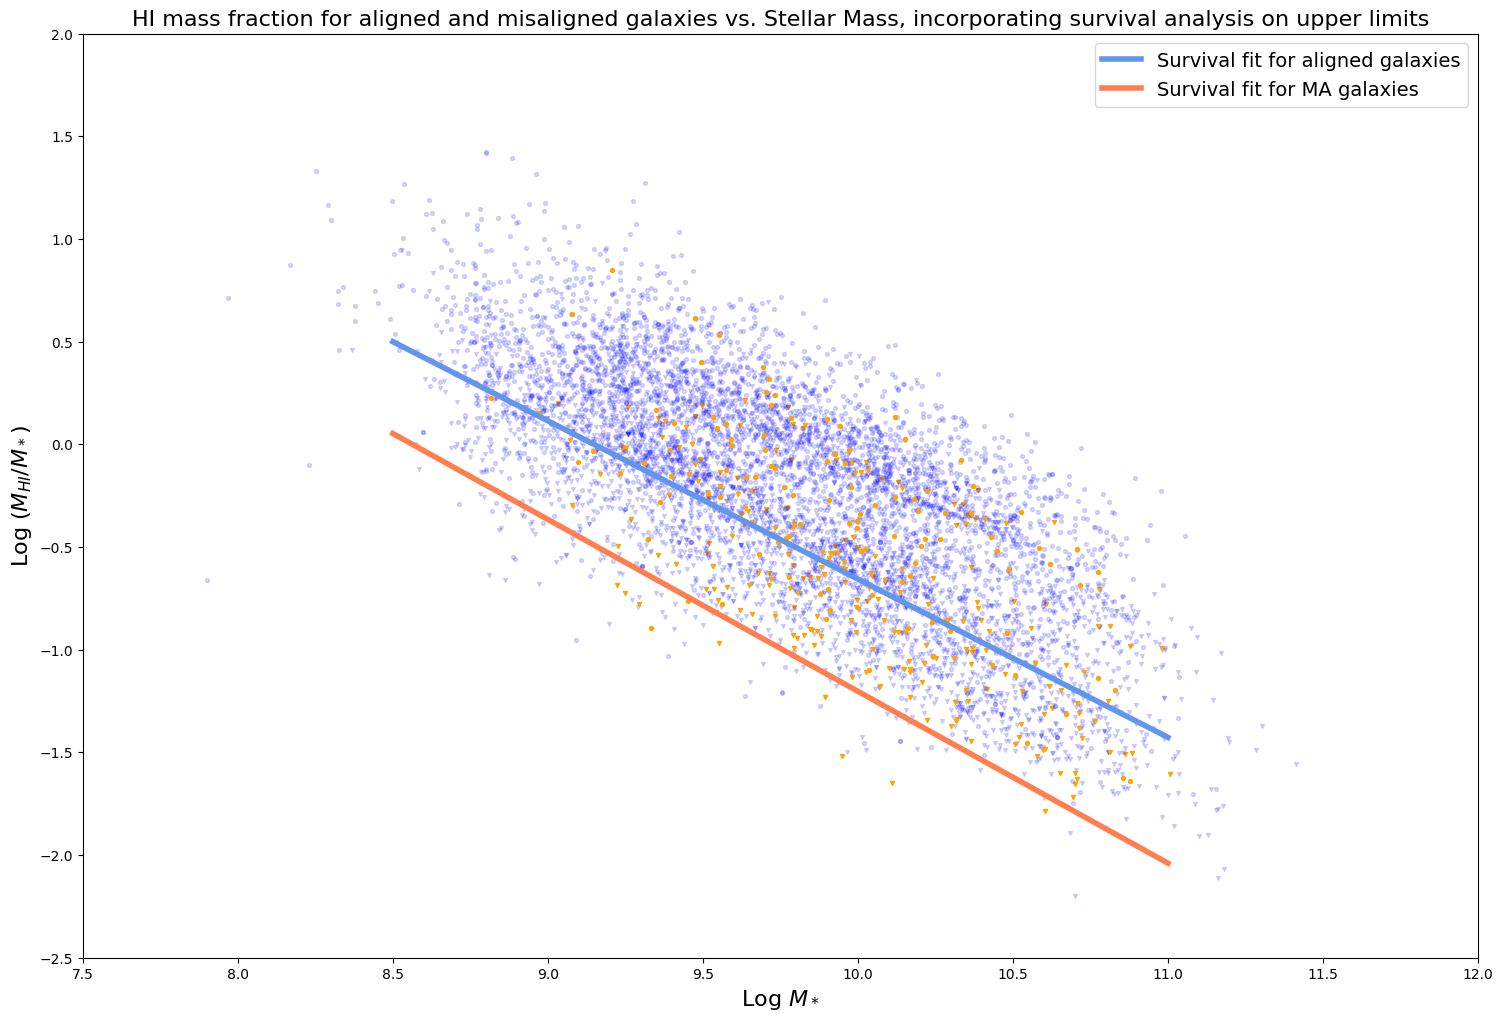

In [31]:
fig = plt.figure(figsize=(18, 12))

AlignedLimCol = 'blue'
AlignedDetCol = 'blue'
MALimCol = 'orange'
MADetCol = 'orange'

AlignedFitCol = 'cornflowerblue'
MAFitCol = 'coral'

# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15)
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol)

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15)
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol)

pts = [8.5, 11]
plt.plot(pts, [(pts[0] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept'], (pts[1] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept']], color = AlignedFitCol, lw = 4, label = 'Survival fit for aligned galaxies')
plt.plot(pts, [(pts[0] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept'], (pts[1] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept']], color = MAFitCol, lw = 4, label = 'Survival fit for MA galaxies')

plt.legend(fontsize=14)
plt.xlim(7.5, 12)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16)
plt.title('HI mass fraction for aligned and misaligned galaxies vs. Stellar Mass, incorporating survival analysis on upper limits', fontsize=16);

In [32]:
print(10**(-1 * ((9.5 * AlignedOut.item(0)['slope'] + AlignedOut.item(0)['intercept']) - (9.5 * MAOut.item(0)['slope'] + MAOut.item(0)['intercept']))))

[0.3065517]


This data provides an even more shocking result, as by this method we conclude that the misaligned galaxies trend at only 30% of the expected HI mass expected at a given stellar mass (based on the difference between the values of the lines at $M_*$ = 9.5 $M_{Sun}$).

In [33]:
'''
# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15);
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol);

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15);
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol);
'''
print('Aligned detection count: ', len(alignedComboMStars[~AlignedLims]))
print('Aligned upper limit count: ', len(alignedComboMStars[AlignedLims]))

print('\nMA detection count: ', len(MAComboMStars[~MALims]))
print('MA upper limit count: ', len(MAComboMStars[MALims]))

Aligned detection count:  3175
Aligned upper limit count:  3297

MA detection count:  108
MA upper limit count:  229


Unfortunately, we see that these sets are ≥ 50% non-detections, so this survival anlysis method will not necessarily provide us with reasonable or accurate results. Still, there are other statistical methods we can apply to this data to account for the presence of upper limits.

First, however, we can investigate if we can derive useful data for this survival analysis method for smaller selections of stellar mass. That is, if the upper limits skew towards higher stellar mass galaxies, then we can draw conclusions about the amount of expected HI found in misaligned galaxies within a more restricted (lower) stellar mass range.

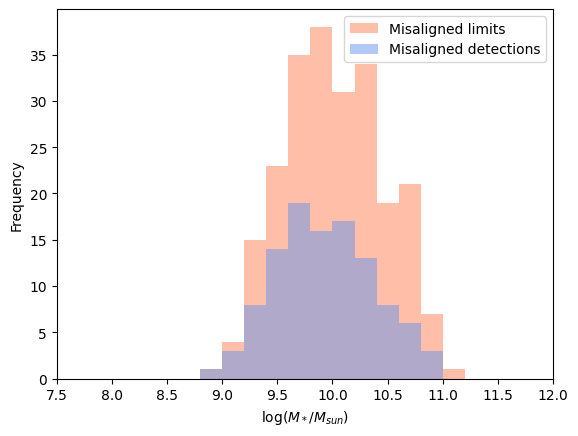

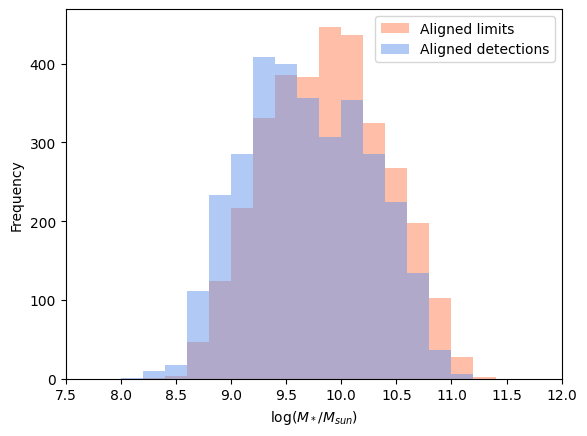

In [34]:
'''
Data:
Aligned upper limits: alignedComboMStars[AlignedLims]
Aligned detections: alignedComboMStars[~AlignedLims]

MA upper limits: MAComboMStars[MALims]
MA detections: MAComboMStars[~MALims]
'''

Bins = np.arange(8, 11.5, 0.2)

# Co-plotted histogram for frequency of misaligned gal detections vs. stellar mass and frequency of misaligned upper limits vs. stellar mass
plt.hist(MAComboMStars[MALims], alpha = 0.5, label = 'Misaligned limits', bins = Bins, color = 'coral')
plt.hist(MAComboMStars[~MALims], alpha = 0.5, label = 'Misaligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()

# and co-plotted histogram for frequency of aligned detections vs. stellar mass and frequency of aligned upper limits vs stellar mass
plt.hist(alignedComboMStars[AlignedLims], alpha = 0.5, label = 'Aligned limits', bins = Bins, color = 'coral')
plt.hist(alignedComboMStars[~AlignedLims], alpha = 0.5, label = 'Aligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()

Now to introduce the Kaplan-Meier test to produce cumulative distribution functions (CDFs) for the populations:

In [35]:
alignedKM = kaplan_meier(alignedComboMFrac, AlignedLims)
MAKM = kaplan_meier(MAComboMFrac, MALims)

     lim     gs
1      0  0.921
2      0 -0.083
3      0 -0.199
4      0 -0.386
5      0 -0.120
6      1 -0.194
7      1 -1.190
8      1 -0.462
9      1 -0.153
10     0 -1.474
11     0 -0.708
12     1 -1.177
13     0  0.579
14     0  0.365
15     1 -0.261
16     0  0.275
17     0 -0.061
18     0 -0.126
19     1 -0.949
20     0  0.044
21     0  0.503
22     0  0.282
23     0 -0.738
24     0  0.141
25     0 -0.558
26     0  0.177
27     0  0.662
28     0  0.397
29     1 -1.420
30     0  0.046
31     0  0.329
32     0 -0.207
33     0  0.080
34     0  0.448
35     0 -1.181
36     1 -0.963
37     0  0.286
38     0  0.314
39     1 -0.204
40     1 -0.503
41     1 -0.078
42     0 -0.441
43     0  0.327
44     0 -0.443
45     0  0.540
46     1 -0.542
47     1 -0.534
48     1 -0.118
49     1 -0.640
50     1 -0.675
51     1 -0.958
52     1 -0.665
53     1 -1.060
54     1 -0.474
55     0  0.088
56     0  0.264
57     1 -0.129
58     1 -0.714
59     1 -0.307
60     1 -0.014
61     1 -0.576
62     1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



   0 -0.864
2546   1 -0.410
2547   1 -0.417
2548   1 -1.050
2549   1 -0.672
2550   0  0.096
2551   1 -1.003
2552   1 -0.515
2553   1 -1.263
2554   1 -1.317
2555   0  0.273
2556   0 -0.129
2557   1 -0.332
2558   1 -0.635
2559   0  0.167
2560   1 -0.452
2561   1 -1.546
2562   0  0.588
2563   1 -1.201
2564   0 -0.176
2565   1 -0.494
2566   0  0.169
2567   0  0.233
2568   0 -0.652
2569   0 -0.274
2570   1 -1.002
2571   0 -0.118
2572   1 -1.025
2573   0 -0.323
2574   1 -0.540
2575   0 -0.831
2576   1 -1.284
2577   0 -0.525
2578   0 -0.927
2579   0 -0.021
2580   0  0.412
2581   0 -0.150
2582   0  0.368
2583   0 -0.311
2584   0 -0.285
2585   0 -0.221
2586   0  0.229
2587   1 -0.668
2588   1 -1.242
2589   0  0.324
2590   1 -0.490
2591   0  0.059
2592   0  0.213
2593   0 -0.161
2594   0  0.403
2595   0 -0.525
2596   1 -0.410
2597   0 -0.747
2598   1 -0.607
2599   1 -0.895
2600   1 -0.596
2601   0  0.470
2602   0  0.486
2603   1 -0.215
2604   0 -0.073
2605   0 -0.102
2606   0  0.203
2607   0  0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




4869   0 -1.156
4870   0  0.506
4871   1 -0.886
4872   1 -1.175
4873   0 -0.295
4874   0  0.190
4875   0 -0.961
4876   0 -0.273
4877   0  0.115
4878   0  0.301
4879   0 -0.585
4880   1 -0.921
4881   1 -0.551
4882   0 -0.248
4883   1 -0.621
4884   1 -0.837
4885   0  0.235
4886   1 -0.620
4887   1 -0.483
4888   1 -1.175
4889   1 -0.200
4890   1 -1.471
4891   1 -1.330
4892   1 -1.329
4893   1 -0.493
4894   1 -0.229
4895   1 -0.573
4896   1 -1.475
4897   1 -1.118
4898   0 -0.694
4899   1 -1.601
4900   0 -0.198
4901   1 -0.762
4902   0 -0.237
4903   0  0.053
4904   0  0.193
4905   0 -0.011
4906   0  0.251
4907   1 -0.633
4908   0 -0.037
4909   1 -1.029
4910   0  0.290
4911   0  0.316
4912   0 -0.447
4913   0  0.431
4914   0  0.579
4915   0  0.393
4916   1 -1.215
4917   0 -0.076
4918   1 -0.780
4919   1 -0.105
4920   1 -0.136
4921   1 -0.142
4922   1 -1.148
4923   0  0.714
4924   0  0.404
4925   1 -0.496
4926   0  0.299
4927   1 -0.586
4928   0 -0.812
4929   0  0.355
4930   0  0.534
4931   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



   0  0.537
5502   0  0.516
5503   0  0.741
5504   1 -0.418
5505   0  0.358
5506   0 -0.110
5507   1 -0.974
5508   0 -1.211
5509   1 -0.052
5510   1 -0.818
5511   1 -0.416
5512   0 -1.029
5513   0 -0.111
5514   0  0.662
5515   0 -0.292
5516   0  0.287
5517   0 -0.137
5518   0  0.352
5519   0  0.172
5520   1 -0.469
5521   1 -0.790
5522   0  0.259
5523   1 -0.742
5524   1 -0.486
5525   0 -1.224
5526   0 -0.259
5527   0  0.193
5528   0 -0.213
5529   0  0.224
5530   0  0.856
5531   0 -1.392
5532   1 -0.502
5533   1 -0.441
5534   0  0.059
5535   1 -0.178
5536   1 -0.609
5537   1 -0.359
5538   0 -0.033
5539   1 -1.068
5540   0 -1.493
5541   1 -0.330
5542   1 -1.576
5543   1 -0.284
5544   0  0.080
5545   1 -0.604
5546   0  0.453
5547   1 -1.216
5548   1 -1.210
5549   0  0.130
5550   0  0.668
5551   0  0.275
5552   0  0.431
5553   0  0.263
5554   0  0.362
5555   0 -0.358
5556   1 -0.627
5557   0 -0.152
5558   1 -0.585
5559   0 -0.256
5560   0 -1.123
5561   0 -0.397
5562   0  0.134
5563   0  0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



   0 -1.125
129   0  0.101
130   1 -0.914
131   0 -0.578
132   1 -0.759
133   0  0.257
134   1 -0.310
135   1 -0.522
136   1 -1.487
137   1 -1.039
138   0 -1.456
139   0 -0.226
140   0 -0.705
141   0 -0.911
142   1 -0.012
143   1 -0.992
144   1 -0.249
145   1 -0.606
146   1 -0.628
147   1 -0.883
148   1  0.136
149   1 -0.975
150   1 -0.407
151   1 -0.325
152   1 -1.284
153   1 -0.628
154   1 -0.543
155   1 -0.466
156   0  0.130
157   1 -0.790
158   1 -0.596
159   0 -0.005
160   1 -1.348
161   0 -0.947
162   1  0.086
163   1  0.199
164   1 -0.529
165   1 -0.792
166   0 -0.266
167   0  0.045
168   1  0.153
169   1 -0.701
170   0 -0.669
171   1 -0.481
172   1 -0.687
173   0 -0.856
174   0 -0.463
175   1 -1.481
176   1 -0.493
177   1 -0.968
178   1 -0.494
179   1 -0.070
180   1 -0.976
181   1 -1.117
182   1 -0.669
183   1 -0.828
184   1 -1.346
185   0 -0.237
186   1 -1.259
187   0 -0.621
188   1 -0.365
189   1 -0.994
190   0 -0.330
191   1 -0.528
192   0  0.531
193   1 -1.496
194   1 -0.14

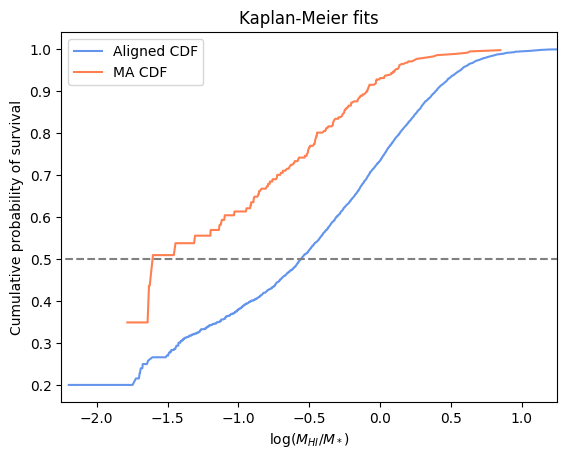

In [36]:
plt.plot(alignedKM['km']['x'], alignedKM['km']['surv'], label = 'Aligned CDF', color = 'cornflowerblue')
plt.plot(MAKM['km']['x'], MAKM['km']['surv'], label = 'MA CDF', color = 'coral')
plt.xlabel('log($M_{HI}$/$M_*$)')
plt.ylabel('Cumulative probability of survival')
plt.title('Kaplan-Meier fits')
plt.plot([-3, 6], [0.5, 0.5], linestyle = '--', color = 'gray')
plt.xlim(-2.25, 1.25)
plt.legend()
plt.show()

I have implemented the Pipe3D data, which includes specific star formation rate data. This is to investigate if there is a significant correlation between star formation rate and HI deficiency.

In [37]:
WA_SFR = []
MA_SFR = []
SFR_WA_masses = []
SFR_MA_masses = []


for gal in dataTable:
    if str(gal['log_SFR_Ha']) != 'nan':
        if gal['plateifu_2'] != '': # Misaligned, so has an entry from the misaligned galaxy fits file
            MA_SFR.append(gal['log_SFR_Ha'] - gal['LOGMSTARS'])
            SFR_MA_masses.append(gal['LOGMSTARS'])
        elif gal['plateifu_2'] == '': # Aligned, so does not
            WA_SFR.append(gal['log_SFR_Ha'] - gal['LOGMSTARS'])
            SFR_WA_masses.append(gal['LOGMSTARS'])

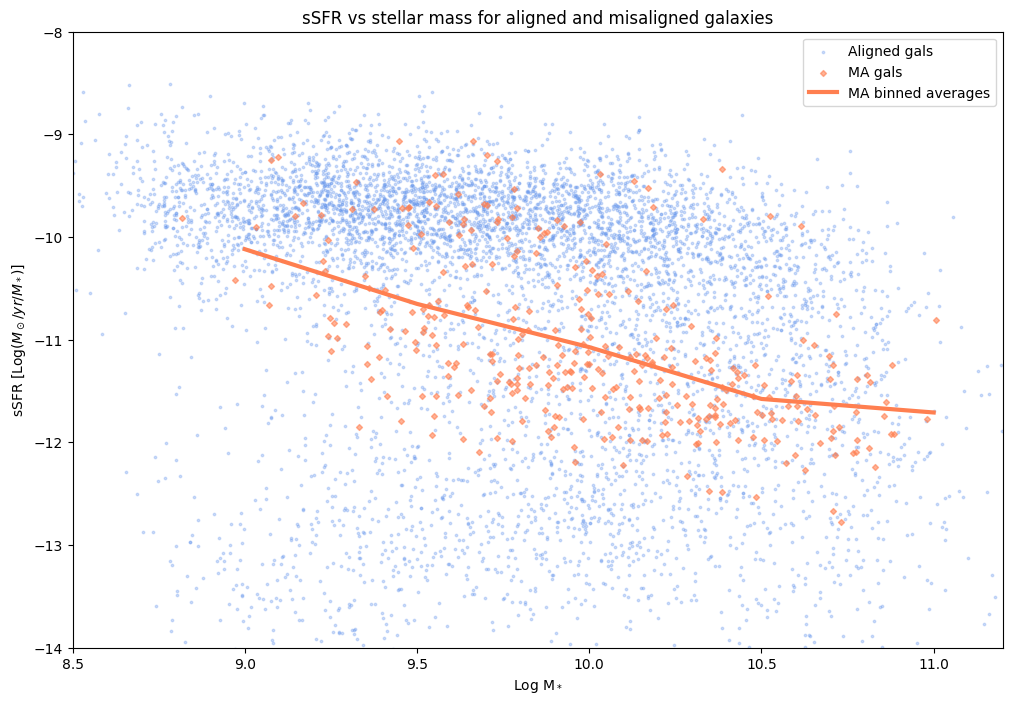

In [43]:
plt.figure(figsize = (12,8))
plt.scatter(SFR_WA_masses, WA_SFR, s = 3, color = 'cornflowerblue', label = 'Aligned gals', alpha = 0.3)
plt.scatter(SFR_MA_masses, MA_SFR, s = 9, marker = 'D', color = 'coral', label = 'MA gals', alpha = .6)

WA_SFR_bins = scipy.stats.binned_statistic(SFR_WA_masses, WA_SFR, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])
MA_SFR_bins = scipy.stats.binned_statistic(SFR_MA_masses, MA_SFR, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])

# plt.plot([8.5, 9, 9.5, 10, 10.5, 11], WA_SFR_bins[0], color = 'cornflowerblue', label = 'Aligned binned averages',
         # lw = 3)
plt.plot([8.5, 9, 9.5, 10, 10.5, 11], MA_SFR_bins[0], color = 'coral', label = 'MA binned averages',
         lw = 3)


plt.xlabel('Log M$_*$')
plt.ylabel('sSFR [Log($M_\odot/yr/M_*$)]')
plt.legend()
plt.title('sSFR vs stellar mass for aligned and misaligned galaxies')
plt.xlim(8.5, 11.2)
plt.ylim(-14, -8)
plt.show()